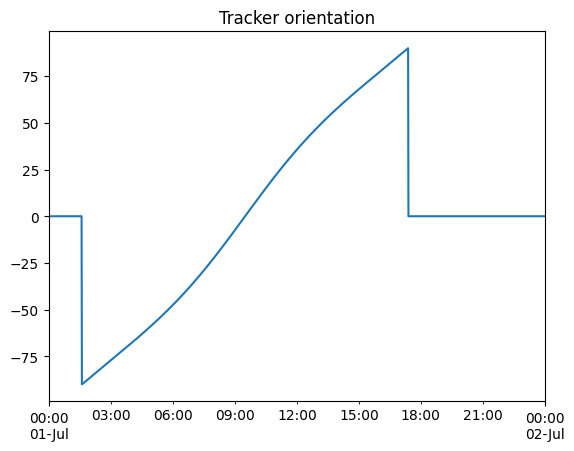

AttributeError: 'NoneType' object has no attribute 'plot'

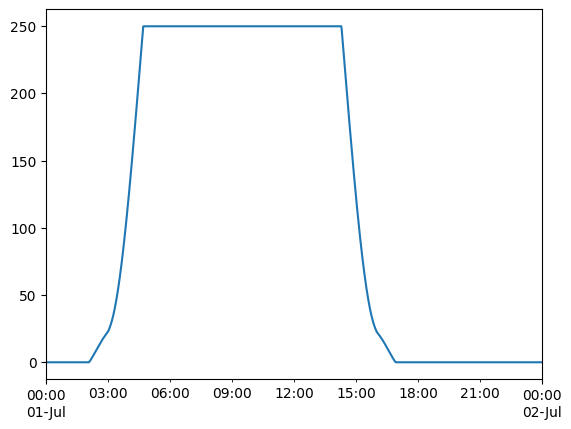

In [22]:
import pvlib

from pvlib.modelchain import ModelChain
from pvlib.location import Location
from pvlib.pvsystem import PVSystem, Array, SingleAxisTrackerMount
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

import matplotlib.pyplot as plt

import pandas as pd

latitude = 47.4
longitude = 8.54

location = Location(latitude=latitude, longitude=longitude, tz='Etc/GMT+2', altitude=550, name='Zuerich-ETZ')

sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')

sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']

inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

temperature_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

system = PVSystem(surface_tilt=30,surface_azimuth=180,module_parameters=module,
                  inverter_parameters=inverter, temperature_model_parameters=temperature_parameters,
                  modules_per_string=4, strings_per_inverter=1)

modelchain = ModelChain(system, location)

times = pd.date_range(start="2022-07-01", end="2022-07-02", freq="1min", tz=location.tz)

clear_sky = location.get_clearsky(times)

# modelchain.run_model(clear_sky)

mount = SingleAxisTrackerMount(axis_tilt=0, axis_azimuth=180,max_angle=90,backtrack=False)

sol_pos = location.get_solarposition(times)
orientation = mount.get_orientation(solar_zenith=sol_pos['apparent_zenith'], solar_azimuth=sol_pos['azimuth'])

orientation['tracker_theta'].fillna(0).plot(title='Tracker orientation')
plt.show()

array = Array(mount=mount, module_parameters=module, temperature_model_parameters=temperature_parameters,
              modules_per_string=4, strings=1)

system_sat = PVSystem(arrays=[array], inverter_parameters=inverter)

modelchain_sat = ModelChain(system_sat, location)

modelchain.run_model(clear_sky)

modelchain.results.ac.plot()
modelchain_sat.results.ac.plot(figsize=(16,20))
plt.legend(['Fixed System', 'Single Axis Tracking'])

# modelchain.results.ac.plot()
plt.show()